In [29]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['font.size'] = 11

In [33]:
#Returns the FRACTION of cumulative infected cells c, current T-infected cells iT, current B-infected cells iB, 
# and current immune cells z. All quantities normalized by "S_0", the initial number of susceptible cells.
#10 rates govern the system dynamics in addition to the 4 initial conditions
def model(t, y, dT, dB, betaT, betaB, cTB, aT, aB, mu, psiT, psiB):
    c, iT, iB, z = y
    dcdt  = betaT * iT + betaB * iB
    diTdt = -(dT + cTB) * iT + (betaT * iT + betaB * iB) - psiT*iT*z
    diBdt = - dB * iB + cTB * iT - psiB*iB*z
    dzdt  = (aT*iT+aB*iB - mu) * z
    return [dcdt, diTdt, diBdt, dzdt]

#Same as above, but this function returns the cumulative Tachyzoites and Bradyzoites separatley. 
def modelCTCB(t, y, dT, dB, betaT, betaB, cTB, aT, aB, mu, psiT, psiB):
    cT, cB, iT, iB, z = y
    dcTdt = betaT * iT + betaB * iB - cTB * iT
    dcBdt = cTB * iT
    diTdt = -(dT + cTB) * iT + (betaT * iT + betaB * iB) - psiT*iT*z
    diBdt = - dB * iB + cTB * iT - psiB*iB*z
    dzdt  = (aT*iT+aB*iB - mu) * z
    return [dcTdt, dcBdt, diTdt, diBdt, dzdt]

#There are two methods to consider using in the solve_ivp method:
#The default 'RK45' is usually sufficient but occasionally produces small (unphysical) oscillations at late times.
#When this is observed, try using the method 'Radau'.

#Each of the functions below produces a plot and returns the figure which can be saved.
#params refers to the tuple of parameters accepted by model. 
#ic refers to the tuple of initial conditions. 
#The function values are stored at the times in tList
#The upper y limit is an optional argument yMax. 
# If yMax is unspecified or given an invalid input, the default full plot range is used.

#Plots I_T, I_B, and Z/10000
def cellNumberPlot(params, ic, tList, yMax=0, method='RK45',title=''):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    plt.plot(t, S0*iT, color='red',label='Tachyzoite')
    plt.plot(t, S0*iB, color='blue',label='Bradyzoite')
    plt.plot(t, S0*z/10000, color='green',label='Immune Cells')
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('# of cells',fontsize=14);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlim(0,tmax); 
    plt.title(title)
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig    

#compares I_T and I_B for the wild and mutant types 
#note that the "params" only need to be specified for the wild type.
def wildVsMutantSideBySide(params, ic, tList, yMax=0, method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    
    plt.subplot(1,2,1)
    plt.plot(t,S0*iT,color='red', label=r'Tachyzoite')
    plt.plot(t,S0*iB,color='blue', label=r'Bradyzoite')
    plt.xlabel('Days post infection', fontsize=14); plt.ylabel('Infected cells',fontsize=14)
    plt.title('Wild Type');
    if yMax > 0:
        plt.ylim(0,yMax)
    
    #sets cTB=0 for the mutant, keeps all other parameters fixed.
    paramsList = list(params); paramsList[4]=0; params = tuple(paramsList)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    
    plt.subplot(1,2,2)
    plt.plot(t,S0*iT,color='red', label=r'Tachyzoite')
    plt.plot(t,S0*iB,color='blue', label=r'Bradyzoite')
    plt.xlabel('Days post infection',fontsize=14);  
    plt.title(r'$\Delta$BFD-1')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    if yMax > 0:
        plt.ylim(0,yMax)

    plt.tight_layout(rect=(0,0,1.5,.7),pad=.75)
    plt.show()    
    return fig

#Compares the number of tachyzoite-infected cells for the WT and mutant in one plot.
def wildVsMutantTachyzoites(params, ic, tList, yMax=0,method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    paramsList = list(params); paramsList[4]=0; params = tuple(paramsList)
    soln2 = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t2 = soln.t
    c2, iT2, iB2, z2 = soln2.y
    plt.plot(t, S0*iT, color='red',label='WT')
    plt.plot(t2, S0*iT2, color='red',linestyle='dotted',label=r'$\Delta$BFD-1')
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('# of tachyzoite-infected cells',fontsize=14);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlim(0,tmax); 
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig

#Compares the cumulative number of infected cells for the WT and mutant in one plot.
def wildVsMutantCumulative(params, ic, tList, yMax=0,method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    paramsList = list(params); paramsList[4]=0; params = tuple(paramsList)
    soln2 = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t2 = soln.t
    c2, iT2, iB2, z2 = soln2.y
    plt.plot(t, S0*c, color='purple',label='WT')
    plt.plot(t2, S0*c2, color='purple',linestyle='dotted',label=r'$\Delta$BFD-1')
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('Cumulative # of infected cells',fontsize=14);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlim(0,tmax); 
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig

#Compares the cumulative number of T-infected cells for the WT and mutant in one plot.
def wildVsMutantCumulativeT(params, ic, tList, yMax=0,method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(modelCTCB, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    cT, cB, iT, iB, z = soln.y
    paramsList = list(params); paramsList[4]=0; params = tuple(paramsList)
    soln2 = solve_ivp(modelCTCB, tspan, ic, args=params, method=method, t_eval=tList)
    t2 = soln.t
    cT2, cB2, iT2, iB2, z2 = soln2.y
    plt.plot(t, S0*cT, color='red',label='WT')
    plt.plot(t2, S0*cT2, color='red',linestyle='dotted',label=r'$\Delta$BFD-1')
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('Cumulative # of T-infected cells',fontsize=14);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlim(0,tmax); 
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig

#Compares the cumulative number of B-infected cells for the WT and mutant in one plot.
def wildVsMutantCumulativeB(params, ic, tList, yMax=0,method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    soln = solve_ivp(modelCTCB, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    cT, cB, iT, iB, z = soln.y
    paramsList = list(params); paramsList[4]=0; params = tuple(paramsList)
    soln2 = solve_ivp(modelCTCB, tspan, ic, args=params, method=method, t_eval=tList)
    t2 = soln.t
    cT2, cB2, iT2, iB2, z2 = soln2.y
    plt.plot(t, S0*cB, color='blue',label='WT')
    plt.plot(t2, S0*cB2, color='blue',linestyle='dotted',label=r'$\Delta$BFD-1')
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('Cumulative # of B-infected cells',fontsize=14);
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.xlim(0,tmax); 
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig

#Compares the cumulative number of infected cells for three different choices of cTB as specified in cTBList
def cumulativeInfectionComparison(params, ic, tList, cTBList, yMax=0, method='RK45'):
    S0=10**8
    fig, ax = plt.subplots()
    tmin = tList[0]; tmax = tList[-1]; tspan = (tmin,tmax)
    paramsList = list(params); paramsList[4]=cTBList[0]; params = tuple(paramsList)
    soln = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t = soln.t
    c, iT, iB, z = soln.y
    paramsList = list(params); paramsList[4]=cTBList[1]; params = tuple(paramsList)
    soln2 = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t2 = soln.t
    c2, iT2, iB2, z2 = soln2.y
    paramsList = list(params); paramsList[4]=cTBList[2]; params = tuple(paramsList)
    soln3 = solve_ivp(model, tspan, ic, args=params, method=method, t_eval=tList)
    t3 = soln.t
    c3, iT3, iB3, z3 = soln3.y    
    plt.plot(t, S0*c,  color='purple',linestyle='dotted',label=r'$c_{TB}=%1.2f$'%cTBList[0])
    plt.plot(t, S0*c2, color='purple',linestyle='dashed',label=r'$c_{TB}=%1.2f$'%cTBList[1])
    plt.plot(t, S0*c3, color='purple',label=r'$c_{TB}=%1.2f$'%cTBList[2])
    plt.xlabel('Days post infection',fontsize=14); plt.ylabel('Cumulative # of infected cells',fontsize=14);
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
    plt.xlim(0,tmax); 
    #allows for the optional adjustment of ymax, otherwise use the default full plot range. 
    if yMax > 0:
        plt.ylim(0,yMax)
    plt.show()
    return fig

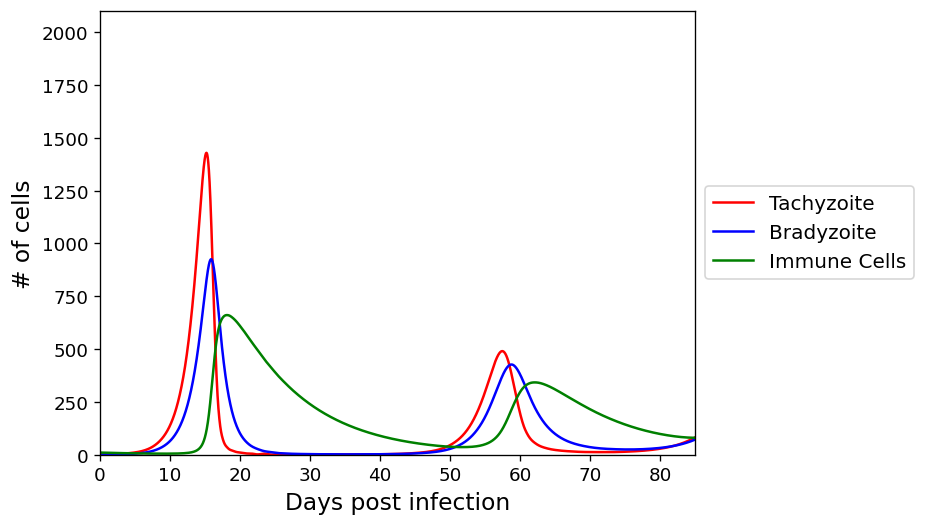

In [42]:
dT = 1; dB = 0.01; betaT = 1.7; betaB = .2; cTB = .25; aT = 10**5; aB = .2*aT; mu = .1; psiT = 50; psiB = .2*psiT
params = (dT,dB,betaT,betaB,cTB,aT,aB,mu,psiT,psiB)
iT0 = 1e-8; c0 = 0; iB0 = 0; z0 = 1e-3; y0 = (c0, iT0, iB0, z0)
tmin = 0; tmax = 85; dt = .0025; t = np.linspace(tmin,tmax,int((tmax-tmin)/dt))
fig=cellNumberPlot(params,y0,t,yMax=2100)
fig.savefig('TandBImmuneResponse.png', format='png',bbox_inches='tight')